In [1]:
import torch

import numpy as np

from tqdm import tqdm

import torch.nn as nn
import torch.nn.functional as F


from sklearn.utils import shuffle

from torch.utils.data import TensorDataset, DataLoader

In [56]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Cuda Device Available")
  print("Name of the Cuda Device: ", torch.cuda.get_device_name())
  print("GPU Computational Capablity: ", torch.cuda.get_device_capability())


Cuda Device Available
Name of the Cuda Device:  NVIDIA GeForce RTX 3090
GPU Computational Capablity:  (8, 6)


In [5]:
def get_datapoint(size, positive):
    mu, sigma = 0.5, 0.05 # mean and standard deviation
    s = np.random.normal(mu, sigma, size)
    if positive:
        s[0] = np.random.normal(0.6, 0.05, 1)[0]
    return s

In [16]:
def get_dataset(positive):
    return np.array([get_datapoint(2000, positive) for _ in range(10000)])

In [119]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    y = y.astype(int)
    return np.eye(num_classes, dtype='uint8')[y]

In [120]:
X_all_pos = get_dataset(True)
X_all_neg = get_dataset(False)

y_all_pos = np.ones(len(X_all_pos))
y_all_neg = np.zeros(len(X_all_neg))

X_all = np.vstack([X_all_pos, X_all_neg])
y_all = np.hstack([y_all_pos, y_all_neg])

X_shuff, y_shuff = shuffle(X_all, y_all, random_state=0)

y_categorical = to_categorical(y_shuff, 2)

In [143]:
HIDDEN_LAYERS = [100, 50]
BATCH_SIZE = 5
dims = [800]


class myNetwork(nn.Module):

    def __init__(self, dims, layers):
        super().__init__()
        hiddenlayers = []
        curr_dim = dims
        for size in layers:
            hiddenlayers.append(nn.Linear(curr_dim, size))
            curr_dim = size
        self.hiddenlayers = nn.ModuleList(hiddenlayers)
        self.lastLayer = nn.Linear(curr_dim, 2)


    def forward(self,x):
        
        for layer in self.hiddenlayers:
            x = F.relu(layer(x))
            
        x = F.softmax(self.lastLayer(x), dim=1)
        
        return x
loss_fn = nn.CrossEntropyLoss()

In [147]:
def train(model, x, y, optimizer, criterion):
    
    model.train()
    x, y = x.to(device), y.to(device)
    model.zero_grad()
    output = model(x)
    loss =criterion(output,y)
    loss.backward()
    optimizer.step()

    correct = sum(y == torch.round(output))[0]
    
    return loss, output, correct

def validate(model, x, y, criterion):
    
    model.eval()
    x, y = x.to(device), y.to(device)
    output = model(x)
    loss =criterion(output,y)
    
    correct = sum(y == torch.round(output))[0]
    
    return loss, output, correct

def num_correct(predictions, y):
    for idx, i in enumerate(predictions):
        i  = torch.round(i[1])
        if i == y_train[idx][1]:
            correct += 1
    return correct

In [148]:
results = []

In [154]:
results2 = []

In [155]:

for dim in list(range(1200, 1400, 20)):
    
    
    X_cut = X_shuff[:,:dim]
    
    print(f"now working with x shape {X_cut.shape}")
    
    tensor_x = torch.Tensor(X_cut) # transform to torch tensor
    tensor_y = torch.Tensor(y_categorical)

    my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
    train_set, val_set = torch.utils.data.random_split(my_dataset, [15000, 5000])
    
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE)
    val_loader = DataLoader(val_set, batch_size=len(val_set))

    for trial in range(5):
    
        model = myNetwork(dim, HIDDEN_LAYERS)
        model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        for epoch in range(62):
            train_loss_total = 0
            train_correct = 0
            val_loss_total = 0
            val_correct = 0

            for bidx, batch in enumerate(train_loader):
                x_train, y_train = batch
                loss, predictions, correct = train(model,x_train,y_train, optimizer, loss_fn)
                train_correct += correct
                train_loss_total += loss

            training_acc = train_correct/len(train_set)
            training_loss = train_loss_total/(bidx + 1)

            for bidx, batch in enumerate(val_loader):
                x_val, y_val = batch
                loss, predictions, correct = validate(model,x_val,y_val,loss_fn)
                val_correct += correct
                val_loss_total += loss

            val_acc = val_correct/len(val_set)
            val_loss = val_loss_total/(bidx + 1)
            
            avg_acc = ((training_acc + val_acc)/2)
            print(f"{epoch}:{avg_acc:.3f}", end='  ')
            
            if training_acc > 0.7 and val_acc > 0.7:
                break
            
            if epoch > 60:
                epoch = -1
                break
            
            
        print("")
        print(f"dims: {dim}, trial: {trial} ,epochs: {epoch}")
        results2.append([dim, epoch])
#             print(f"Epoch {epoch} training_acc : {training_acc:.3f}; training_loss: {training_loss:.3f}, val_acc : {val_acc:.3f}; val_loss: {val_loss:.3f}")
        
    

now working with x shape (20000, 1200)
0:0.500  1:0.502  2:0.503  3:0.503  4:0.505  5:0.507  6:0.508  7:0.513  8:0.514  9:0.561  10:0.647  11:0.701  12:0.646  13:0.753  14:0.745  
dims: 1200, trial: 0 ,epochs: 14
0:0.499  1:0.499  2:0.495  3:0.497  4:0.497  5:0.498  6:0.498  7:0.498  8:0.498  9:0.498  10:0.498  11:0.498  12:0.498  13:0.498  14:0.498  15:0.498  16:0.498  17:0.498  18:0.498  19:0.498  20:0.498  21:0.498  22:0.498  23:0.498  24:0.498  25:0.498  26:0.498  27:0.498  28:0.498  29:0.498  30:0.498  31:0.498  32:0.498  33:0.498  34:0.498  35:0.498  36:0.498  37:0.498  38:0.498  39:0.498  40:0.498  41:0.498  42:0.498  43:0.498  44:0.498  45:0.498  46:0.498  47:0.498  48:0.498  49:0.498  50:0.498  51:0.498  52:0.498  53:0.498  54:0.498  55:0.498  56:0.498  57:0.498  58:0.498  59:0.498  60:0.498  61:0.498  
dims: 1200, trial: 1 ,epochs: -1
0:0.499  1:0.500  2:0.501  3:0.500  4:0.501  5:0.502  6:0.504  7:0.508  8:0.514  9:0.516  10:0.533  11:0.613  12:0.668  13:0.698  14:0.672  15:

In [153]:
results

[[700, 13],
 [700, -1],
 [700, -1],
 [700, 11],
 [700, 12],
 [720, 14],
 [720, 12],
 [720, -1],
 [720, -1],
 [720, 13],
 [740, -1],
 [740, -1],
 [740, 39],
 [740, -1],
 [740, 16],
 [760, 12],
 [760, -1],
 [760, 18],
 [760, 12],
 [760, 13],
 [780, 14],
 [780, -1],
 [780, -1],
 [780, -1],
 [780, -1],
 [800, 16],
 [800, 16],
 [800, 17],
 [800, 14],
 [800, -1],
 [820, 9],
 [820, -1],
 [820, -1],
 [820, 15],
 [820, -1],
 [840, -1],
 [840, 13],
 [840, 15],
 [840, 14],
 [840, 12],
 [860, 17],
 [860, 14],
 [860, 13],
 [860, 14],
 [860, -1],
 [880, 14],
 [880, 13],
 [880, -1],
 [880, -1],
 [880, 15],
 [900, 20],
 [900, -1],
 [900, -1],
 [900, 38],
 [900, 19],
 [920, -1],
 [920, 14],
 [920, 47],
 [920, 17],
 [920, 56],
 [940, -1],
 [940, 12],
 [940, 14],
 [940, 15],
 [940, 15],
 [960, -1],
 [960, 13],
 [960, 16],
 [960, 15],
 [960, 13],
 [980, -1],
 [980, 29],
 [980, 15],
 [980, 13],
 [980, 33],
 [1000, 15],
 [1000, -1],
 [1000, -1],
 [1000, 16],
 [1000, 17],
 [1020, -1],
 [1020, 14],
 [1020, -1

In [152]:
results = [[700, 13],
 [700, -1],
 [700, -1],
 [700, 11],
 [700, 12],
 [720, 14],
 [720, 12],
 [720, -1],
 [720, -1],
 [720, 13],
 [740, -1],
 [740, -1],
 [740, 39],
 [740, -1],
 [740, 16],
 [760, 12],
 [760, -1],
 [760, 18],
 [760, 12],
 [760, 13],
 [780, 14],
 [780, -1],
 [780, -1],
 [780, -1],
 [780, -1],
 [800, 16],
 [800, 16],
 [800, 17],
 [800, 14],
 [800, -1],
 [820, 9],
 [820, -1],
 [820, -1],
 [820, 15],
 [820, -1],
 [840, -1],
 [840, 13],
 [840, 15],
 [840, 14],
 [840, 12],
 [860, 17],
 [860, 14],
 [860, 13],
 [860, 14],
 [860, -1],
 [880, 14],
 [880, 13],
 [880, -1],
 [880, -1],
 [880, 15],
 [900, 20],
 [900, -1],
 [900, -1],
 [900, 38],
 [900, 19],
 [920, -1],
 [920, 14],
 [920, 47],
 [920, 17],
 [920, 56],
 [940, -1],
 [940, 12],
 [940, 14],
 [940, 15],
 [940, 15],
 [960, -1],
 [960, 13],
 [960, 16],
 [960, 15],
 [960, 13],
 [980, -1],
 [980, 29],
 [980, 15],
 [980, 13],
 [980, 33],
 [1000, 15],
 [1000, -1],
 [1000, -1],
 [1000, 16],
 [1000, 17],
 [1020, -1],
 [1020, 14],
 [1020, -1],
 [1020, -1],
 [1020, -1],
 [1040, -1],
 [1040, -1],
 [1040, -1],
 [1040, -1],
 [1040, -1],
 [1060, -1],
 [1060, -1],
 [1060, 16],
 [1060, -1],
 [1060, -1],
 [1080, -1],
 [1080, -1],
 [1080, -1],
 [1080, 15],
 [1080, -1],
 [1100, -1],
 [1100, 16],
 [1100, 16],
 [1100, -1],
 [1100, 15],
 [1120, 20],
 [1120, 16],
 [1120, -1],
 [1120, 13],
 [1120, 14],
 [1140, -1],
 [1140, 16],
 [1140, 13],
 [1140, -1],
 [1140, -1],
 [1160, -1],
 [1160, 16],
 [1160, -1],
 [1160, 12],
 [1160, 14],
 [1180, -1],
 [1180, 14],
 [1180, -1],
 [1180, -1],
 [1180, -1]]

In [156]:
results2

[[1200, 14],
 [1200, -1],
 [1200, 16],
 [1200, -1],
 [1200, -1],
 [1220, -1],
 [1220, -1],
 [1220, -1],
 [1220, 16],
 [1220, -1],
 [1240, -1],
 [1240, 19],
 [1240, -1],
 [1240, -1],
 [1240, -1],
 [1260, -1],
 [1260, 18],
 [1260, 16],
 [1260, 17],
 [1260, 14],
 [1280, -1],
 [1280, -1],
 [1280, -1],
 [1280, -1],
 [1280, -1],
 [1300, -1],
 [1300, 19],
 [1300, -1],
 [1300, -1],
 [1300, -1],
 [1320, -1],
 [1320, -1],
 [1320, 15],
 [1320, -1],
 [1320, -1],
 [1340, -1],
 [1340, -1],
 [1340, -1],
 [1340, -1],
 [1340, -1],
 [1360, -1],
 [1360, -1],
 [1360, -1],
 [1360, -1],
 [1360, -1],
 [1380, -1],
 [1380, -1],
 [1380, 16],
 [1380, -1],
 [1380, 16]]

In [160]:
result_all = results + results2

In [161]:
result_succ = [x for x in result_all if x[1] > -1]
result_fail = [x for x in result_all if x[1] == -1]

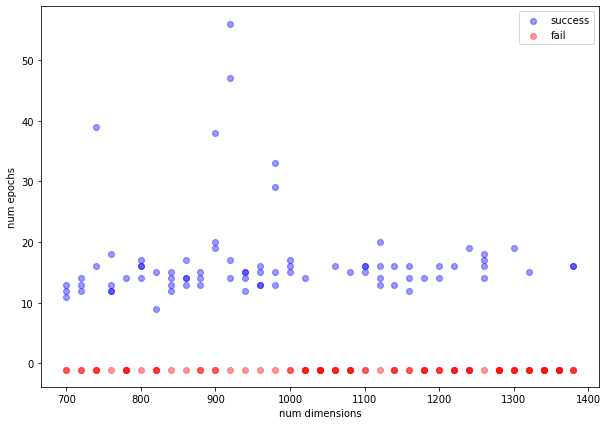

In [168]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize = (10, 7))

plt.scatter(*zip(*result_succ), color = 'blue',alpha = 0.4, label = 'success')
plt.scatter(*zip(*result_fail), color = 'red',alpha = 0.4, label = 'fail')
plt.xlabel('num dimensions')
plt.ylabel('num epochs')

plt.legend(loc='upper right')

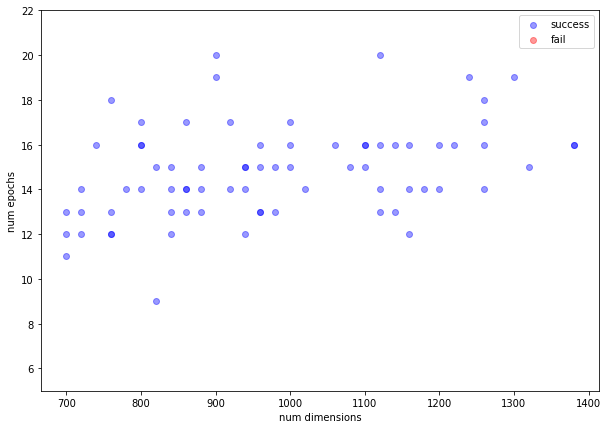

In [170]:
fig = plt.figure(figsize = (10, 7))

plt.scatter(*zip(*result_succ), color = 'blue',alpha = 0.4, label = 'success')
plt.scatter(*zip(*result_fail), color = 'red',alpha = 0.4, label = 'fail')
plt.xlabel('num dimensions')
plt.ylabel('num epochs')
plt.ylim((5, 22))

plt.legend(loc='upper right')

In [171]:
from collections import defaultdict

In [172]:
dic = defaultdict(int)
for r in result_all:
    if r[1] > -1:
        dic[(r[0])] += 0.2
    else:
        dic[(r[0])] += 0

In [174]:
res_prob = list(dic.items())

Text(0, 0.5, 'probablity of succeeding')

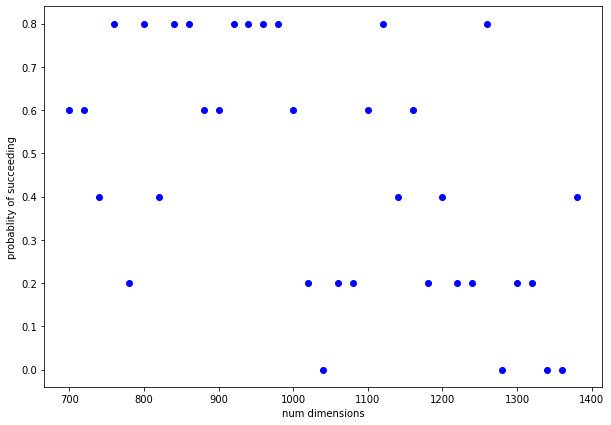

In [176]:
fig = plt.figure(figsize = (10, 7))

plt.scatter(*zip(*res_prob), color = 'blue')
plt.xlabel('num dimensions')
plt.ylabel('probablity of succeeding')


In [177]:
dic = defaultdict(int)
for r in result_all:
    if r[1] > -1:
        dic[(r[0] - r[0]%100)] += 0.5
    else:
        dic[(r[0] - r[0]%100)] += 0

Text(0, 0.5, 'probablity of succeeding')

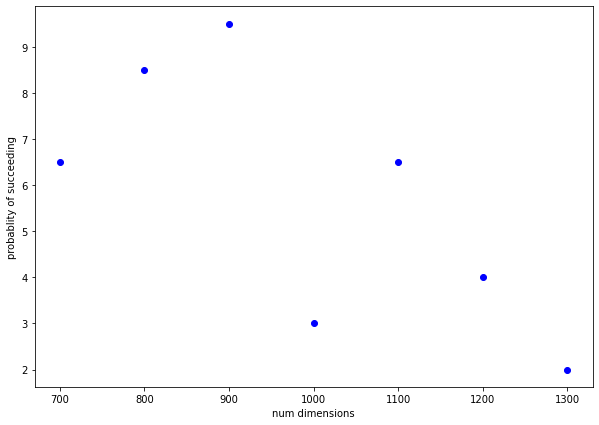

In [178]:
res_prob = list(dic.items())
fig = plt.figure(figsize = (10, 7))

plt.scatter(*zip(*res_prob), color = 'blue')
plt.xlabel('num dimensions')
plt.ylabel('probablity of succeeding')
